In [70]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""Data preprocessing for HCMC survey dataset"""

__author__ = "Anna Buch, Heidelberg University"
__email__ = "a.buch@stud.uni-heidelberg.de"


# Feature selection for content losses done by Logistic Regression

Due to many zero losses especially in content losses, a binary regression was tested to distinguish between occured losses and no losses. The before applied elastic net result showed that the elastic net algorithm might be a bit too complex for the moderate size of training set and the imbalnced distribution with in the response (many zero losses compared to only a very a left skewed distribution of occured content losses)  

*Sources*
Geron 2019: https://learning.oreilly.com/library/view/hands-on-machine-learning/9781492032632/ch04.html#idm45022190228392

In [71]:
import sys
import numpy as np
import pandas as pd

import pickle
import joblib

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import make_scorer, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split, KFold, RepeatedStratifiedKFold, RepeatedKFold, cross_validate, cross_val_predict
from sklearn.pipeline import Pipeline

from scipy import stats

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns


sys.path.insert(0, "../../../")
import utils.utils_feature_selection as fs
import utils.utils_evaluation as e
import utils.utils_figures as f
import utils.settings as s
import utils.pipelines as p
import utils.utils_processing as pp


p.main()  # create/update model settings
#s.init()
seed = s.seed

pd.set_option('display.max_columns', None)
plt.figure(figsize=(20, 10))

import warnings
warnings.filterwarnings('ignore')


target = "Target_relative_contentloss_euro"


<Figure size 2000x1000 with 0 Axes>

In [72]:
## load DS for relative content loss
df_candidates = pd.read_excel("../../../input_survey_data/input_data_contentloss_tueb.xlsx")

df_candidates = df_candidates.drop(["Target_contentloss_euro", "shp_content_value_euro"], axis=1)

print(df_candidates.shape)
df_candidates.tail(2)


(397, 32)


,Target_relative_contentloss_euro,inundation_duration_h,water_depth_cm,contaminations.0,flowvelocity,emergency_measures.1,emergency_measures.2,emergency_measures.3,emergency_measures.4,emergency_measures.7,emergency_measures.8,overall_problem_house,protect_valuables_impl,water_barriers_impl,pumping_equipment_impl,elevation_building_impl,resistant_material_building_impl,electricity_higher_impl,flood_protections_impl,flood_experience,elevation_building_height_cm,bage,b_area,hh_monthly_income_cat,shp_owner,shp_sector,shp_employees,shp_avgmonthly_sale_cat,resilience_govern_careing_increases,contaminations_light,contaminations_heavy,shp_registered_capital_euro
395,NaN,4.0,70.0,0,1,1,0,1,0,0,0,1,1,5,1,1,5,5,5,5,70.0,NaN,130.0,NaN,1,17,2,3,1.0,1,0,11047.7
396,NaN,3.0,100.0,0,1,1,0,1,0,0,0,0,1,5,5,5,5,5,5,4,NaN,5.0,33.0,1.0,1,11,2,3,NaN,1,0,736.5


In [73]:
## impl in data_cleaning
#print(df_candidates.floors.describe())
try: 
    df_candidates = df_candidates[df_candidates.floors < 3, : ]
except:
    pass


### TODO impl this cell in data_cleaning
try:
    #if target=="Target_relative_contentloss_euro": 
    df_candidates = df_candidates.drop("floors", axis=1 )  # remove if still in ds due that it's used for shp_content_value and relative content loss
    df_candidates = df_candidates.drop("buildingtype_moon", axis=1)  # remove due to 64 % missing values   
except:
    pass
try:
    df_candidates = df_candidates.drop("elevation_building_height_cm", axis=1)
    df_candidates = df_candidates.drop(["contaminations_light","contaminations_heavy"], axis=1)
    #df_candidates = df_candidates.drop("resilience_govern_careing_increases", axis=1)
except:
    pass


print(df_candidates.shape)
df_candidates.tail(2)

(397, 29)


,Target_relative_contentloss_euro,inundation_duration_h,water_depth_cm,contaminations.0,flowvelocity,emergency_measures.1,emergency_measures.2,emergency_measures.3,emergency_measures.4,emergency_measures.7,emergency_measures.8,overall_problem_house,protect_valuables_impl,water_barriers_impl,pumping_equipment_impl,elevation_building_impl,resistant_material_building_impl,electricity_higher_impl,flood_protections_impl,flood_experience,bage,b_area,hh_monthly_income_cat,shp_owner,shp_sector,shp_employees,shp_avgmonthly_sale_cat,resilience_govern_careing_increases,shp_registered_capital_euro
395,NaN,4.0,70.0,0,1,1,0,1,0,0,0,1,1,5,1,1,5,5,5,5,NaN,130.0,NaN,1,17,2,3,1.0,11047.7
396,NaN,3.0,100.0,0,1,1,0,1,0,0,0,0,1,5,5,5,5,5,5,4,5.0,33.0,1.0,1,11,2,3,NaN,736.5


In [74]:
## delete features with more than 10% missing values
print("Percentage of missing values per feature [%]\n", round(df_candidates.isna().mean().sort_values(ascending=False)[:15]  * 100), 2) 


Percentage of missing values per feature [%]
 Target_relative_contentloss_euro       18.0
resilience_govern_careing_increases    14.0
shp_registered_capital_euro            12.0
bage                                    7.0
hh_monthly_income_cat                   6.0
inundation_duration_h                   2.0
b_area                                  1.0
water_depth_cm                          0.0
contaminations.0                        0.0
electricity_higher_impl                 0.0
shp_avgmonthly_sale_cat                 0.0
shp_employees                           0.0
shp_sector                              0.0
shp_owner                               0.0
flood_experience                        0.0
dtype: float64 2


In [75]:
df_candidates = df_candidates.loc[:,df_candidates.filter(regex="^(?!resilience_*)").columns]
df_candidates = df_candidates.loc[:,df_candidates.filter(regex="^(?!perception_*)").columns]


## Fit model 

In [76]:
# 

In [77]:
## iterate over both targets and store results 
pipe_name = "pipe_logreg"
#pipe_name = "pipe_logreg_bag"


eval_set_list = []
models_trained = {}
model_coef = {}
df_feature_importances = pd.DataFrame(index=df_candidates.drop(target, axis=1).columns.to_list())
models_scores = {}

# Load set of hyperparamters
hyperparams_set = pp.load_config("../../../utils/hyperparameter_sets.json")


model_name = pipe_name.split('_', 1)[1]
print( f"\nApply Logistic regression on {target}:")

## set target as binary class
df_candidates_t = df_candidates
df_candidates[target][df_candidates[target] > 0] = 1
df_candidates[target] = df_candidates[target].astype("Int64")

## clean df from remaining records containg nan
df_candidates_t.dropna(inplace=True)
## TODO test with only nan in target removed

print("Amount of missing target values should be zero: ", df_candidates_t[target].isna().sum())
print("Uses ", df_candidates_t.shape[0], " records, from those have ", 
        { (df_candidates_t[target][df_candidates_t[target]==0.0]).count() }, f" records zero {target.split('_')[1]}")

        
X = df_candidates_t.drop(target, axis=1)  # remove bth targets from X
y = df_candidates_t[target]


from sklearn.ensemble import BaggingClassifier  
param_grid = {
    "name__estimator__penalty": ["elasticnet"],      # alpha: constant mulitplies penality term, alpha = 0 is equivalent to an OLS solved by the LinearRegression
    "name__estimator__C": [1,2,3,4,5, 6, 7, 8, 9],  # inverse reularization strength
    "name__estimator__max_iter": [1,2,3,4],
    "name__estimator__l1_ratio": np.arange(0.0, 1.01, 0.25),     # r = 0, equivalent to Ridge Regression (=L2),  r = 1 equivalent to Lasso Regression (=L1) 
    "name__estimator__tol": [0.0001, 0.001, 0.01, 0.1, 0.5,],
    "name__estimator__solver": ["saga"],
    "name__estimator__class_weight": ["balanced"],
    "name__estimator__random_state": [seed],
}
model = {'model': BaggingClassifier,   # default bootstrap=True
    'kwargs': {'estimator': LogisticRegression()},  # TODO: pass 'random_state':seed to baggingregressor
    'parameters': param_grid,
    }
pipeline = Pipeline( steps = [('name', model['model'] (**model['kwargs']) ) ]  )  # pipeline for Bagging method
     # --> access params in pipline via <estimator>__<parameter> syntax , eg hyperParams for ElasticNet have to start with "name__estimator__<HyperParamName>""

## load pipe for non-transfomred model
pipe = joblib.load(f'./pipelines/{pipe_name}.pkl')

## Hyperparmater and cv setting       
param_grid = hyperparams_set[f"{model_name}_hyperparameters"]

# ## test train split
# X_train, X_test, y_train, y_test = train_test_split(
#     X_unscaled, y, test_size=0.15, 
#     random_state=seed, shuffle=True
# )
# ## normalize X data 
# scaler_for_X = MinMaxScaler().fit(X_train)
# X_train = scaler_for_X.transform(pd.DataFrame(X_train))
# X_test = scaler_for_X.transform(pd.DataFrame(X_test))


## set cv for classification task        
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=seed)

## inner cv with hyperparameter tuning 
model = RandomizedSearchCV(
    estimator= pipeline,  #pipe
    param_distributions=model['parameters'], #param_grid
    cv=cv, 
    scoring="accuracy",#"f1",  # accuracy, f1_macro
    ##"", #"neg_mean_squared_error",#"r2" #TODO classifcation: test also e.g "f1" or recall or "f1_micro", "neg_mean_absolute_error",
    refit=True,   
    random_state=seed
)
model.fit(X, y)

## get coefficient of each predictor
try: 
    model_coefs = model.best_estimator_.named_steps['model'].coef_
    model_intercept = model.best_estimator_.named_steps['model'].intercept_
    #model_pvalue = model.best_estimator_.named_steps['model']. 
    print(f"Intercept for {model_name}: {model_intercept}")
    model_coef[f"{model_name}"] = pd.DataFrame(zip(X_unscaled.columns, model_coefs), columns=['features', 'coef']) 
except:
    pass

        
## outer cv for evaluation metrics (averaged across outer folds)
scores = cross_validate(   # allows specifying multiple metrics for evaluation comparated to cross_val_score
    model, 
    X, y, 
    scoring=["accuracy", "precision", "recall", "f1"],  # Strategy to evaluate the performance of the cross-validated model on the test set.
    cv=cv, 
) 
print("outer CV: ACC: %.3f (%.3f)"%(scores["test_accuracy"].mean(), np.std(scores["test_accuracy"])))
print("outer CV: precision: %.3f (%.3f)"%(scores["test_precision"].mean(), np.std(scores["test_precision"])))
print("outer CV: recall: %.3f (%.3f)"%(scores["test_recall"].mean(), np.std(scores["test_recall"])))
print("outer CV: F1: %.3f (%.3f)"%(scores["test_f1"].mean(), np.std(scores["test_f1"])))
models_scores[f"{model_name}"] = scores ## store scores for FI weighting


## outer cv for predictions (n == sample number of entire dataset)
y_pred = cross_val_predict(
    model, 
    X, y, 
    cv=10, # StartifiedKFold without repeats to have for each sample one predicted value 
    method="predict_proba"
    #method="predict_log_proba"
)
## store highest predicted probabilities and respective empirical values
y_pred_value = np.argmax(y_pred, axis=1)
y_pred_max = np.take_along_axis(
    y_pred, 
    np.expand_dims(
        y_pred_value, 
        axis=1
    ), 
    axis=1
)
predicted_probabilities = pd.DataFrame(
    {
        "y_empirical": y, 
        "y_pred_value":y_pred_value, 
        "y_pred_value_proba": y_pred_max.flatten()
    }
)


## store best trained model
models_trained[f"trained_{model_name}"] = model.best_estimator_

print(f"\nEvaluation of {model_name}")
#y_pred = model.predict_log_proba(X)

#logistic_reg = logistic_reg_cv.best_estimator_

## store trained model for evaluation
filename = f'./models_trained/logisticreg_{target}.sav'
pickle.dump(model, open(filename, 'wb'))


print(f"Best hyperparams: {model.best_params_}")
print('Acc Score : %.3f'%model.best_estimator_.score(X, y)) # how well did the model on the training set
#print('Test Acc Score : %.3f'%logistic_reg.score(X_test, y_test)) # .. compared to the unseen test set for overfitting 
#print("MAE of best model: %.3f" % elastic_net_cv.best_score_)  # TODO check why MAE nan 

## Evaluate model
## get significant features based on absolute coeff values
print("\nSelect features based on absoulte coefficient values")

# # select significant features by using coefs (= linear relationship between features ~ target, adjusted by the regularization terms)
# df_importance = pd.DataFrame({
#     "importances" : np.abs(logistic_reg.coef_)[0], # larger absolute coef value == more important feature
#     }, index= X_unscaled.columns.to_list())
# df_importance = df_importance.loc[df_importance.importances > importances_threshold[target], : ].T      # drop features which dont reduce the loss

importances = e.permutation_feature_importance(model.best_estimator_, X, y, repeats=5, seed=seed)
df_importance = pd.DataFrame(
    {f"{model_name}_importances" : importances[0]},
    index=X_unscaled.columns.to_list(),
) 

df_importance = df_importance.sort_values(f"{model_name}_importances", ascending=False)  # get most important features to the top
print("5 most important features:", df_importance.iloc[:5].index.to_list())
#df_importance = df_importance.loc[df_importance[f"{model_name}_importances"] >= 0.000000, : ]

df_feature_importances = df_feature_importances.merge(
    df_importance[f"{model_name}_importances"], 
    left_index=True, right_index=True, how="outer"
) 

# ## write selected predictors and response to disk
# X_train = pd.DataFrame(X_train)
# X_train.columns = X_unscaled.columns
# y_train = pd.DataFrame(y_train)
# y_train.columns = [target]
# fs.save_selected_features(X_train, y_train, df_importance.columns, filename=f"../../input_survey_data/fs_logisticreg_{target.split('_')[1]}.xlsx")


## evaluate
# scores = cross_validate(elastic_net, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1) # neg_mean_absolute_error
# print(scores)
# # force scores to be positive
#scores = np.abs(logistic_reg.coef_)
#print('Mean MAE: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))



Apply Logistic regression on Target_relative_contentloss_euro:
Amount of missing target values should be zero:  0
Uses  268  records, from those have  {158}  records zero relative


outer CV: ACC: 0.576 (0.075)
outer CV: precision: 0.495 (0.092)
outer CV: recall: 0.593 (0.155)
outer CV: F1: 0.528 (0.090)

Evaluation of logreg
Best hyperparams: {'name__estimator__tol': 0.001, 'name__estimator__solver': 'saga', 'name__estimator__random_state': 42, 'name__estimator__penalty': 'elasticnet', 'name__estimator__max_iter': 3, 'name__estimator__l1_ratio': 0.25, 'name__estimator__class_weight': 'balanced', 'name__estimator__C': 8}
Acc Score : 0.690

Select features based on absoulte coefficient values
5 most important features: ['emergency_measures.4', 'flowvelocity', 'pumping_equipment_impl', 'elevation_building_impl', 'electricity_higher_impl']


In [78]:
# ValueError: Classification metrics can't handle a mix of binary and continuous targets
predicted_probabilities
#pd.Series(y_pred).describe()
# from sklearn.metrics import classification_report
print(classification_report(predicted_probabilities["y_empirical"], predicted_probabilities["y_pred_value"]))
              

              precision    recall  f1-score   support

         0.0       0.66      0.56      0.61       158
         1.0       0.49      0.59      0.53       110

    accuracy                           0.57       268
   macro avg       0.57      0.58      0.57       268
weighted avg       0.59      0.57      0.58       268



In [79]:
## bagging
#         precision    recall  f1-score   support

#          0.0       0.65      0.49      0.56       158
#          1.0       0.46      0.62      0.53       110

#     accuracy                           0.54       268
#    macro avg       0.55      0.55      0.54       268
# weighted avg       0.57      0.54      0.54       268

In [80]:
## without Bagging:
# Train ACC Score : 0.634
# Test ACC Score : 0.512

# with bagging
# Train Acc Score : 0.626
# Test Acc Score : 0.610

df_candidates_t[target].value_counts()
#logistic_reg_cv
# ?logistic_reg
# ?KFold


Target_relative_contentloss_euro
0    158
1    110
Name: count, dtype: Int64

## Evaluation

#### Coefficients of Logistic Regression 

LogReg:  The algorithm estimates the probability of an event occurring by fitting a logistic function to a set of input variables. The coefficients for logistic regression are used to measure the strength of the relationship between the input variables and the output variable.

sklearn:
odds_ratio = exp(coef)
where exp is the exponential function and coef is the coefficient for the input variable. The odds_ratio represents the change in the odds of the output variable for a one-unit increase in the input variable. A value greater than 1 indicates that the odds of the output variable increase with an increase in the input variable

In [81]:
import statsmodels.api as sm

#import statsmodels.api as sm
print(model_coef.keys())
model_coef#["logreg"]

dict_keys([])


{}

In [35]:
model.best_estimator_.c
#models_trained["trained_en"].intercept_

AttributeError: 'RandomizedSearchCV' object has no attribute 'coef_'

In [ ]:
pd.DataFrame(zip(pd.DataFrame(X).columns, np.transpose(models_trained["trained_logreg"].coef_)), columns=['features', 'coef']) 


AttributeError: 'Pipeline' object has no attribute 'coef_'

In [ ]:
logit_model=sm.Logit(y1,x1)
result=logit_model.fit()
print(result.summary())

NameError: name 'y1' is not defined

### Confusion matrix

,0,1
0,97,61
1,54,56


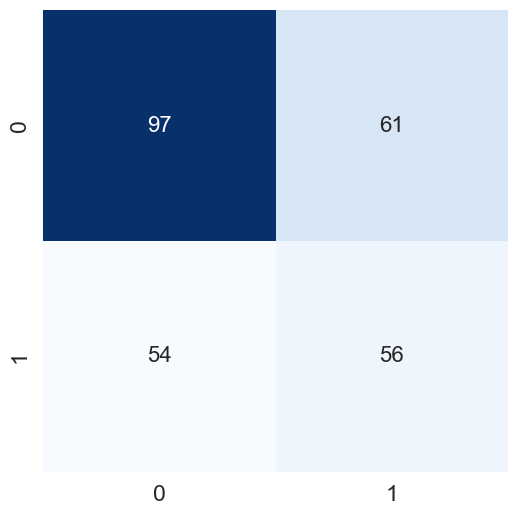

In [37]:
## based on neste cv
f.plot_confusion_matrix(
    predicted_probabilities["y_empirical"],
    predicted_probabilities["y_pred_value"],
    model_name="Logistic_Regression", target_name=target)

### Empirical median ~ predicted median

And further statitics compared to their empirical counterpart.
-  mean / variance / std  compared to empirical distribution

In [38]:
print("Logistic Reg (binary classification): ", target)
e.empirical_vs_predicted(
    X, y.astype(int),
    models_list=[model]    
    #models_list=[model, model_log, model_quantile, model_boxcox, model_sqrt]    
)

## TODO idea: make a median/mean etc of best model as boxplots 8one (3 models for each target)


Logistic Reg (binary classification):  Target_relative_contentloss_euro


,nobs,median,mean,min max,variance
0,268,0,0,"[0, 1]",0.36
1,268,0,0,"[0, 1]",0.43


In [ ]:
#scores = cross_validate(elastic_net, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
#pd.DataFrame(scores).set_index("test_score").sort_index().T

# #Snippet from: https://ubc-cs.github.io/cpsc330/lectures/08_hyperparameter-optimization.html#exhaustive-grid-search-sklearn-model-selection-gridsearchcv
#pd.DataFrame(elastic_net_cv.cv_results_).set_index("rank_test_score").sort_index().T
pd.DataFrame(model.cv_results_)[
        [                                   # only important cv evaluation metrics 
            "mean_test_score",
            "mean_fit_time",
            "rank_test_score",
            "param_name__estimator__C",
            "param_name__estimator__penalty",
            "param_name__estimator__l1_ratio",
            "param_name__estimator__max_iter"
        ]
    ].set_index("rank_test_score").sort_index().T


KeyError: "['param_name__estimator__C', 'param_name__estimator__penalty', 'param_name__estimator__l1_ratio', 'param_name__estimator__max_iter'] not in index"

In [ ]:
## reload models

print(targets)
target = targets[0]

logistic_reg_eval = pickle.load(open(f"./models_trained/logisticreg_{target}.sav", 'rb'))
#elastic_net_eval.get_params()


['Target_contentloss_euro', 'Target_businessreduction']


### Feature importance

In [39]:
print("penalty term: L1=lasso, L2= rigde or elastic_net : " , model.best_params_["model__penalty"])


penalty term: L1=lasso, L2= rigde or elastic_net :  elasticnet


In [40]:
## TODO test to get std of FI _ C:\Users\Anna\Documents\UNI\MA_topic\recycling\sm2t-traffic-speed-model-partial-dependence\SM2T\sm2t-traffic-speed-model_partialDep\traffic_speed_model\modelling.py
#    std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)  # based on RF_fi_ 

#plt.rcParams['axes.grid'] = 'none'
#s

<Figure size 3000x2200 with 0 Axes>

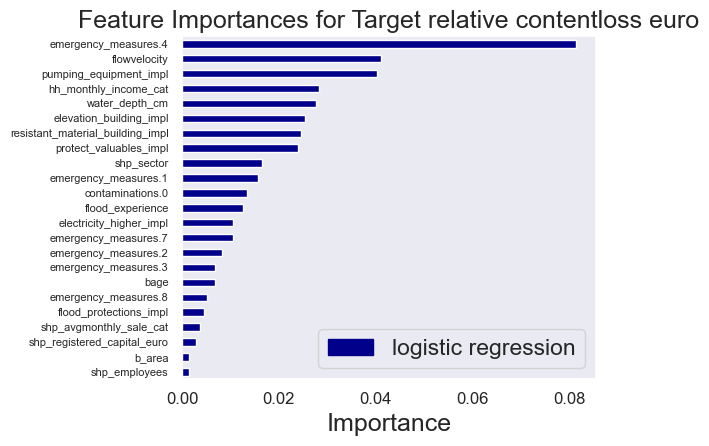

In [56]:
### drop features which dont reduce the loss
#df_feature_importances = s
df_feature_importances = df_feature_importances.loc[df_feature_importances.logreg_importances > 0.001, : ] 
df_feature_importances = df_feature_importances.sort_values("logreg_importances", ascending=True)

plt.figure(figsize=(30, 22), facecolor="w")
df_feature_importances.plot.barh(
    color="darkblue",
    width=0.5,
    # #errorbar="sd",
    # errorbar=("pi", 50), 
    # capsize=.1, errcolor=".5",
    # linewidth=3,
    )
plt.xlabel("Importance")
plt.ylabel("")
plt.title(f"Feature Importances for {target.replace('_',' ')}")


top_bar = mpatches.Patch(color="darkblue", label="logistic regression")
plt.tick_params(axis='x', which='major', labelsize=12)
plt.tick_params(axis='y', which='major', labelsize=8)
plt.legend(handles=[top_bar], loc="lower right")
plt.tight_layout()
#plt.axes().set_facecolor("w")
plt.grid(False)
#plt.show()

#sns.despine(left=True, bottom=True)
## save importance scores and figure
#filepath = f'./models_evaluation/best_xgb_importance_scores_{target}_{pipe_name}'
#if not glob(filepath):
#    df_importance.to_csv(filename, index = False)
#plt.savefig(f'../../../figures/best_en_feature_importance_{target}_{pipe_name}.png', bbox_inches='tight')



In [42]:
# coef = pd.Series(elastic_net.coef_, index = X_train.columns)
# important_features = pd.concat([coef.sort_values().head(10),
#                      coef.sort_values().tail(10)])
# important_features.plot(kind = "barh")
# plt.title("Coefficients in the ElasticNet Model")

### Plot optimal number of features

In [ ]:
elastic_net_eval.c

In [ ]:
# cv results
cv_results = pd.DataFrame(elastic_net_eval.cv_results_)
cv_results


AttributeError: 'ElasticNet' object has no attribute 'cv_results_'

In [ ]:

# plotting cv results
plt.figure(figsize=(16,6))

plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_test_score"])
plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_train_score"])
plt.xlabel('number of features')
plt.ylabel('r-squared')
plt.title("Optimal Number of Features")
plt.legend(['test score', 'train score'], loc='upper left')
